Train classical convolutional NN on MNIST data set.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 
import numpy as np

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print('MNIST Dataset Shape:')
print('x_train: ' + str(x_train.shape) + ', y_train: ' + str(y_train.shape) + ', x_test: ' + str(x_test.shape) + ', y_test: ' + str(y_test.shape))
print('Number of training examples: ', len(x_train))
print('Number of test examples: ', len(x_test))

MNIST Dataset Shape:
x_train: (60000, 28, 28), y_train: (60000,), x_test: (10000, 28, 28), y_test: (10000,)
Number of training examples:  60000
Number of test examples:  10000


Show the first example:

5


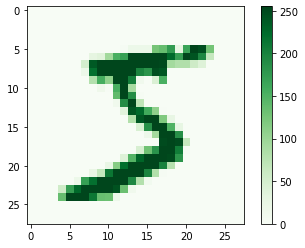

In [4]:
print(y_train[0])

plt.imshow(x_train[0, :, :], cmap='Greens')
plt.colorbar()

Convert train and test images from gray to rgb; and the upscale the images to 32x32 in order to further feed it to the CNN network.

In [5]:
# index number of the image in the training set
ni = x_train.shape[0]
# width in pixels
nx = x_train.shape[1]
# height in pixels
ny = x_train.shape[2]

x_train_rgb = np.ndarray((ni, 32, 32, 3))
i = 0

x_train = x_train.reshape(ni, nx, ny, 1)
x_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_train))

print(x_train_rgb.shape)

# Now resize images to 32x32
# x_train_rgb = tf.image.resize(x_train_rgb, (32, 32))
# print("x_train_rgb after resize: " + str(x_train_rgb.shape))

(60000, 28, 28, 3)


Create classical CNN model

In [6]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Fit the model

Reshape x_train, x_test shapes to 4d tensors to be compatible with Keras expected input.

In [ ]:
print("x_train.shape before: " + str(x_train.shape))
print("x_test.shape before: " + str(x_test.shape))
x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(-1, x_test.shape[1], x_test.shape[2], 1)
print("x_train.shape after: " + str(x_train.shape))
print("x_test.shape after: " + str(x_test.shape))

x_train.shape before: (12049, 28, 28, 1)
x_test.shape before: (1968, 28, 28, 1)
x_train.shape after: (12049, 28, 28, 1)
x_test.shape after: (1968, 28, 28, 1)


In [ ]:
tf.config.run_functions_eagerly(True)
print(x_train.shape)
print(x_test.shape)
model.fit(x_train, y_train, 
          batch_size=128,
          epochs=1, verbose=1, validation_data=(x_test, y_test))

(12049, 28, 28, 1)
(1968, 28, 28, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


95/95 [==============================] - 36s 381ms/step - loss: 0.0100 - accuracy: 0.9983 - val_loss: 0.0022 - val_accuracy: 0.9995


Evaluate the model

In [ ]:
cnn_results = model.evaluate(x_test, y_test)

 5/62 [=>............................] - ETA: 1s - loss: 3.3754e-09 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


62/62 [==============================] - 2s 32ms/step - loss: 0.0022 - accuracy: 0.9995
